# Ringed planetary transit code and PLATO

In [1]:
%matplotlib inline
import numpy as np
import ringed_planet_transit as rpt
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

## Inclusion of PLATO noise sources and stellar surface effects

As a very quick test of a simple ringed planet signal relative to PLATO and stellar surface noise sources I modified PSLS.py to use ringed_planet_transit.py instead of the Mandel & Agol (2002, MA02) method. I ran three instances (each with different random seeds):
* the original code with no transit
* the original MA02 code
* the rpt code with no rings
* the rpt code with a single ring (1.8<r/rp<2.2, T=0.1, gamma=pi/32, shown below)

Transit parameters in common are (set in PSLS example unless noted):
* impact parameter = 0.0 (seems to be assumed by PSLS so I kept it constant)
* planet radius = 0.5 jupiter radii
* orbital period = 10 days
* planet semimajor axis = 1.0 AU

Stellar parameters in common:
* 11th mag star
* Teff = 5750 K
* logg = 4.353
* limb darkening coeffs = 0.25, 0.75

In [2]:
p_secs = 10.*24.*3600. # planetary orbital period in seconds

### Original - no transit

In [3]:
orig_data_nt = np.genfromtxt("data/sim_notransit.dat", names=["time", "dflux_ppm", "flag"])

data scatter: 3.4e-04


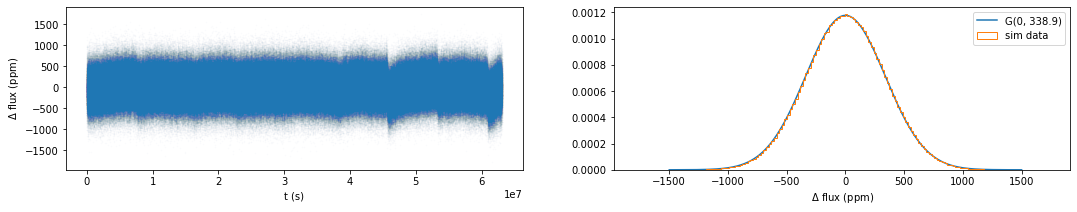

In [4]:
plt.figure(figsize=(18,3))
plt.subplot(121)
plt.scatter(orig_data_nt["time"], orig_data_nt["dflux_ppm"], s=1, alpha=0.01)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.subplot(122)
stdev = np.std(orig_data_nt["dflux_ppm"])
print("data scatter: {:.1e}".format(stdev*1E-6))
_x = np.linspace(-1500,1500,1000)
plt.plot(_x, norm(scale=stdev).pdf(_x), label="G(0, {:.1f})".format(stdev))
plt.hist(orig_data_nt["dflux_ppm"], histtype='step', 
         bins=int(0.1*np.sqrt(orig_data_nt.size)), label="sim data",
         density=True, zorder=10)
plt.legend()
plt.xlabel(r"$\Delta$ flux (ppm)")
plt.show()

Lets have a closer look at a section of the light curve.

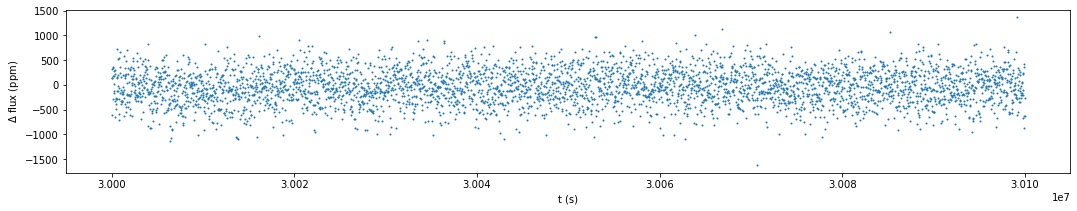

In [5]:
sel = (orig_data_nt["time"]>3E7) & (orig_data_nt["time"]<3.01E7)
plt.figure(figsize=(18,3))
plt.scatter(orig_data_nt["time"][sel], orig_data_nt["dflux_ppm"][sel], s=1, alpha=1)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.show()

A scatter in the simulated data of approx. E-4 requires ring model Ngrid approx. 20 in order that modelling errors are an order of magnitude smaller. There are large systematic shifts in the data, these are particularly clear at the later end of the light curve. There is also a lot of smaller scale structure, I gather this is stochastic time-varying structure on the stellar surface. Modelling through the use of Gaussian processes would be great here (I've heard good things about `celerite`)... another time perhaps. The noise is nicely modelled by a Gaussian anyway. Clearly a rigorous analysis of the underlying variability would yield far more accurate transit fitting results. I'll proceed with something embarassingly simple for now.

get_trend.py calls a small c++ lib I wrote which simply measures a moving window mean and standard error given a kernel size (half-width technically) and interpolates in this for the requested time points. I implemented it in pure python (+ numpy) first but it was too slow to be practical, so a bit of c++ was necessary. This method works fine if your light curve points are regularly and densely sampled (PLATO: check). The kernel width is the key parameter here, too wide and you miss small timescale variability (and it's expensive to compute), too narrow and you potentially subtract trends that you're interested in (e.g. planets). I've implemented it such that it will do a bit of sigma clipping to remove significant outliers, or mask points corresponding to known signals if requested.

n.b. The simulated PLATO data is sampled with a 21 second integration time, and a total of 25 second cadence. The simulated transit is ~1600s wide, or 64 PLATO observations at that cadence.

In [6]:
from get_trend import get_trend

In [7]:
# kernel half-width of 128 samples means kernel is 4x the width of the transit...
# although there is no transit present in this data set
t0 = time()
trend, error = get_trend(orig_data_nt["time"], orig_data_nt["dflux_ppm"], 128)
print("trend measured in {:.3f}s".format(time()-t0))

trend measured in 15.537s


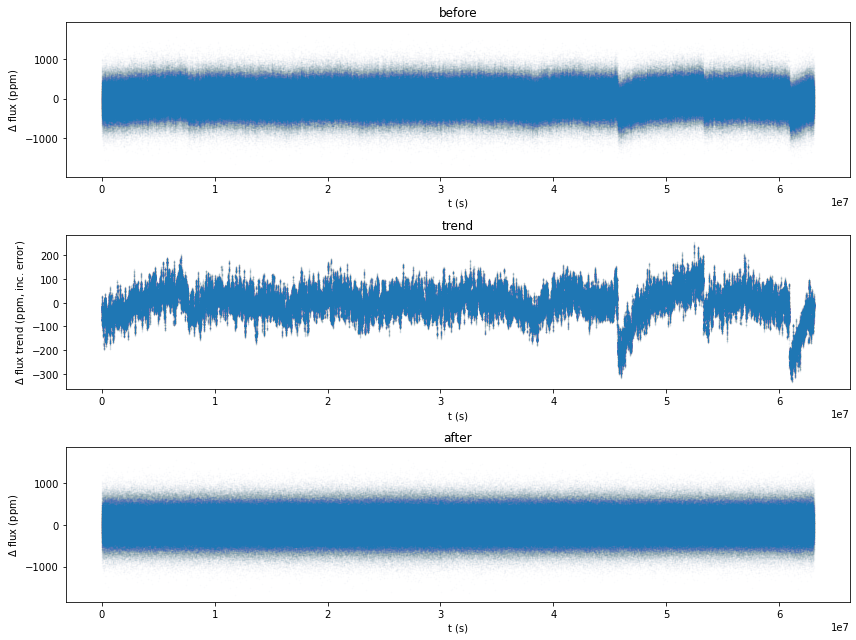

In [8]:
plt.figure(figsize=(12,9))

plt.subplot(311)
plt.scatter(orig_data_nt["time"], orig_data_nt["dflux_ppm"], s=1, alpha=0.01)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.title("before")

plt.subplot(312)
plt.scatter(orig_data_nt["time"], trend, s=1, alpha=0.01)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux trend (ppm, inc. error)")
plt.title("trend")

plt.subplot(313)
plt.scatter(orig_data_nt["time"], orig_data_nt["dflux_ppm"]-trend, s=1, alpha=0.01)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.title("after")

plt.tight_layout()
plt.show()

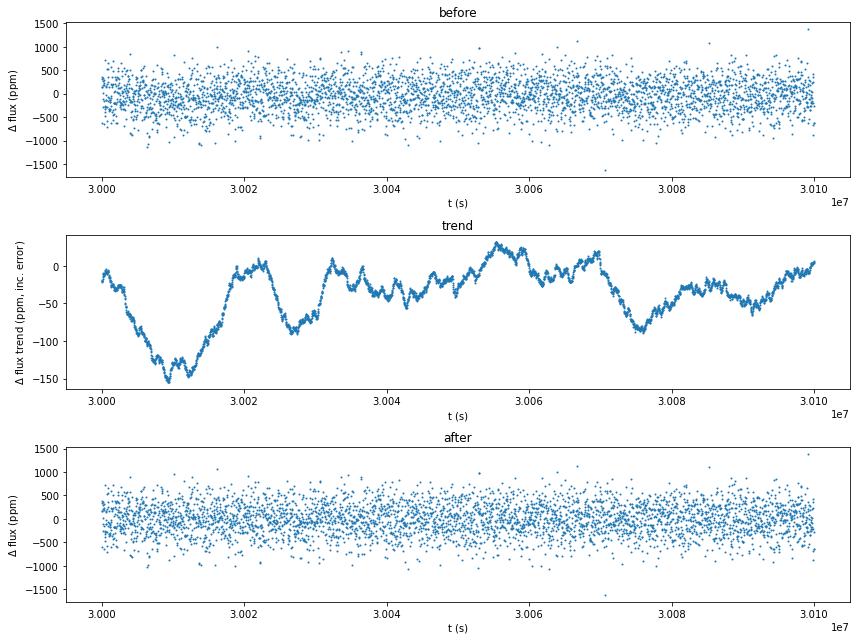

In [9]:
sel = (orig_data_nt["time"]>3E7) & (orig_data_nt["time"]<3.01E7)

plt.figure(figsize=(12,9))

plt.subplot(311)
plt.scatter(orig_data_nt["time"][sel], orig_data_nt["dflux_ppm"][sel], s=1)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.title("before")

plt.subplot(312)
plt.scatter(orig_data_nt["time"][sel], trend[sel], s=1)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux trend (ppm, inc. error)")
plt.title("trend")

plt.subplot(313)
plt.scatter(orig_data_nt["time"][sel], (orig_data_nt["dflux_ppm"]-trend)[sel], s=1)
plt.xlabel("t (s)")
plt.ylabel(r"$\Delta$ flux (ppm)")
plt.title("after")

plt.tight_layout()
plt.show()

That has dealt with the longer term trends at least. Lets see what a real transit looks like.

### Original w/ transit (no rings)

In [10]:
orig_data = np.genfromtxt("data/sim_orig.dat", names=["time", "dflux_ppm", "flag"])
# I'll rely on the data mask to remove the signal as I know where it is.
_t1, _e1 = get_trend(orig_data["time"], orig_data["dflux_ppm"], 128, 
                     sigma_clip=False, 
                     data_mask=( (orig_data["time"] % p_secs < 215200)
                                |(orig_data["time"] % p_secs > 216800)))
orig_data["dflux_ppm"] -= _t1

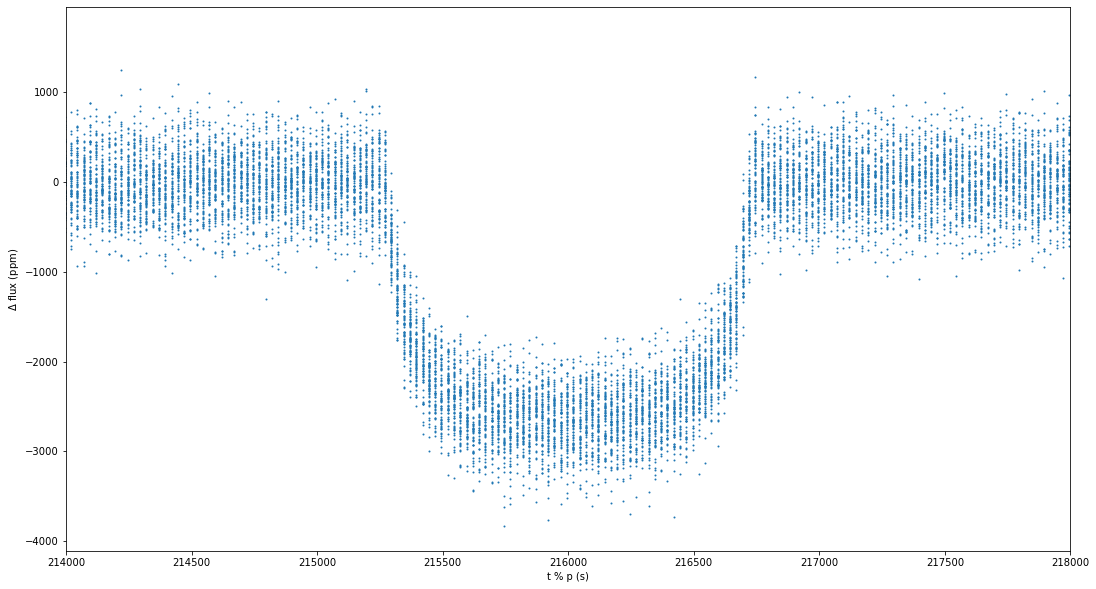

In [11]:
def plot_transit(t,f,p):
    plt.figure(figsize=(18,10))
    plt.scatter(t % p, f, s=1)
    plt.xlabel("t % p (s)")
    plt.ylabel(r"$\Delta$ flux (ppm)")
    plt.xlim(214000,218000)
    plt.show()
    
plot_transit(orig_data["time"],orig_data["dflux_ppm"],p_secs)

n.b. the vertical banding is due to having an integer multiple of the sampling cadence as the orbital period, and phase folding about this period.

I can also use get_trend.py to clean the transit.

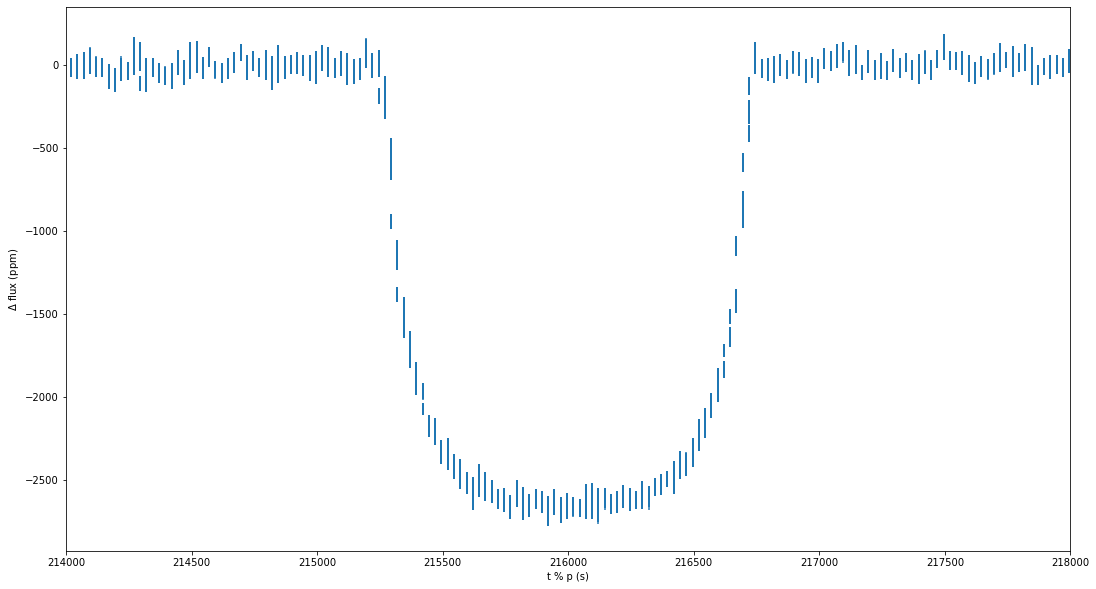

In [12]:
def plot_clean_transit(_t,_f,p):
    t = _t % p
    sel = (t>210000) & (t<222000)
    t = t[sel]
    order = np.argsort(t)
    f = _f[sel][order]
    t = t[order]

    _t2, _e2 = get_trend(t, f, 30)

    plt.figure(figsize=(18,10))
    plt.errorbar(t, _t2, yerr=_e2, fmt=',')
    plt.xlim(214000,218000)
    plt.xlabel("t % p (s)")
    plt.ylabel(r"$\Delta$ flux (ppm)")
    plt.show()

plot_clean_transit(orig_data["time"], orig_data["dflux_ppm"], p_secs)

### RPT no rings

In [13]:
rptn_data = np.genfromtxt("data/sim_norings.dat", names=["time", "dflux_ppm", "flag"])
_t3, _e3 = get_trend(rptn_data["time"], rptn_data["dflux_ppm"], 128, 
                     sigma_clip=False, 
                     data_mask=( (rptn_data["time"] % p_secs < 215200)
                                |(rptn_data["time"] % p_secs > 216800)))
rptn_data["dflux_ppm"] -= _t3

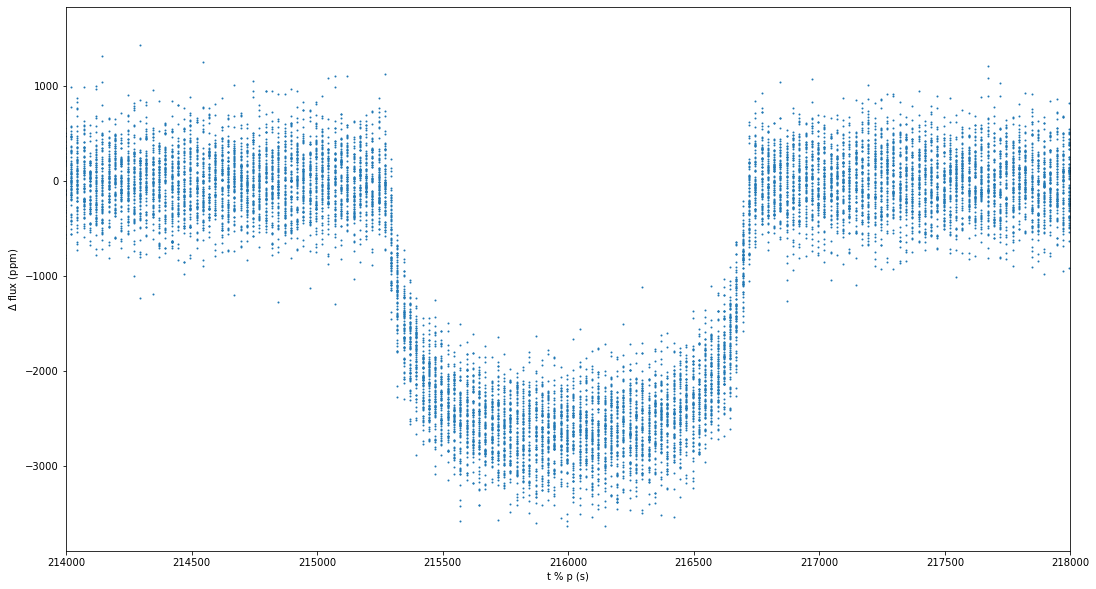

In [14]:
plot_transit(rptn_data["time"],rptn_data["dflux_ppm"],p_secs)

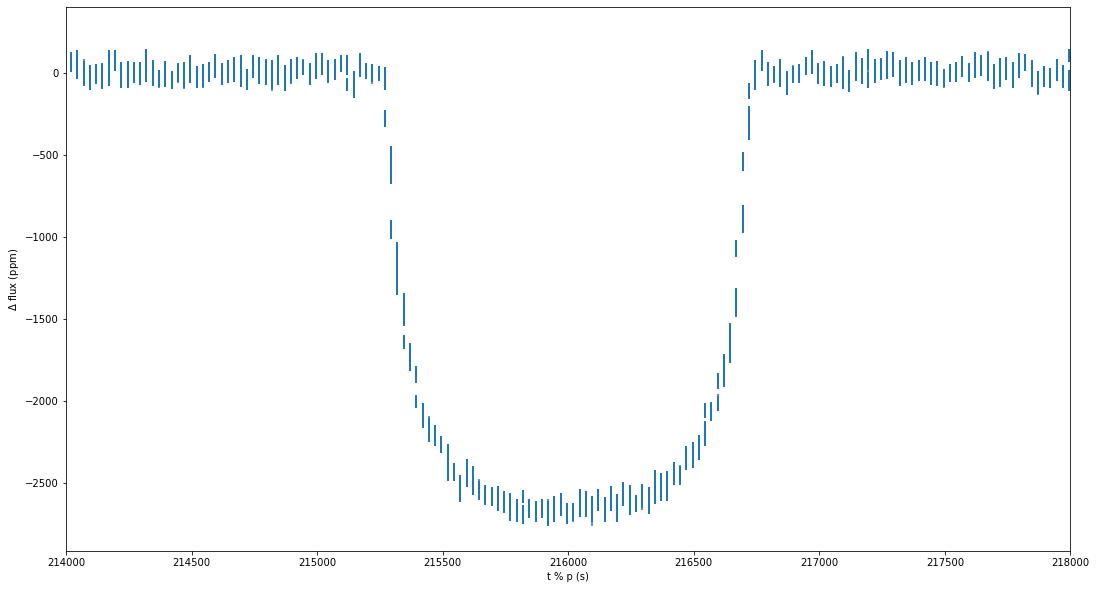

In [15]:
plot_clean_transit(rptn_data["time"], rptn_data["dflux_ppm"], p_secs)

### The RPT ringed planet model

The transparency mask for the ringed planet I'll be modelling.

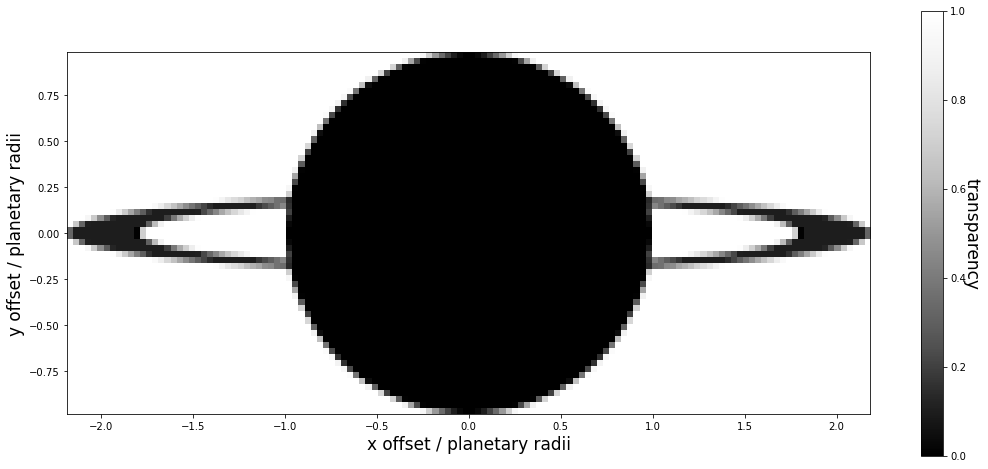

In [16]:
# the rings to model
rings = [
    (1.8,2.2,0.1),
]
# Inclination angle relative to the line of sight to the observer in radians.
inc_angle = np.pi/32
# build and show the occulter
p,x,y,A = rpt.build_ringed_occulter(rings=rings, gamma=inc_angle, Ngrid=30, full_output=True)
shp = np.array(p.shape)
plt.figure(figsize=(18*shp/shp.max()))
plt.imshow(p.T, origin='lower left', cmap='Greys_r', 
           extent=[x.min(),x.max(),y.min(),y.max()])
cbar = plt.colorbar()
plt.xlabel("x offset / planetary radii", fontsize=17)
plt.ylabel("y offset / planetary radii", fontsize=17)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("transparency", rotation=270, fontsize=17)
plt.show()

### RPT rings

In [17]:
rptr_data = np.genfromtxt("data/sim_rings.dat", names=["time", "dflux_ppm", "flag"])
_t4, _e4 = get_trend(rptr_data["time"], rptr_data["dflux_ppm"], 128, 
                     sigma_clip=False, 
                     data_mask=( (rptr_data["time"] % p_secs < 215200)
                                |(rptr_data["time"] % p_secs > 216800)))
rptr_data["dflux_ppm"] -= _t4

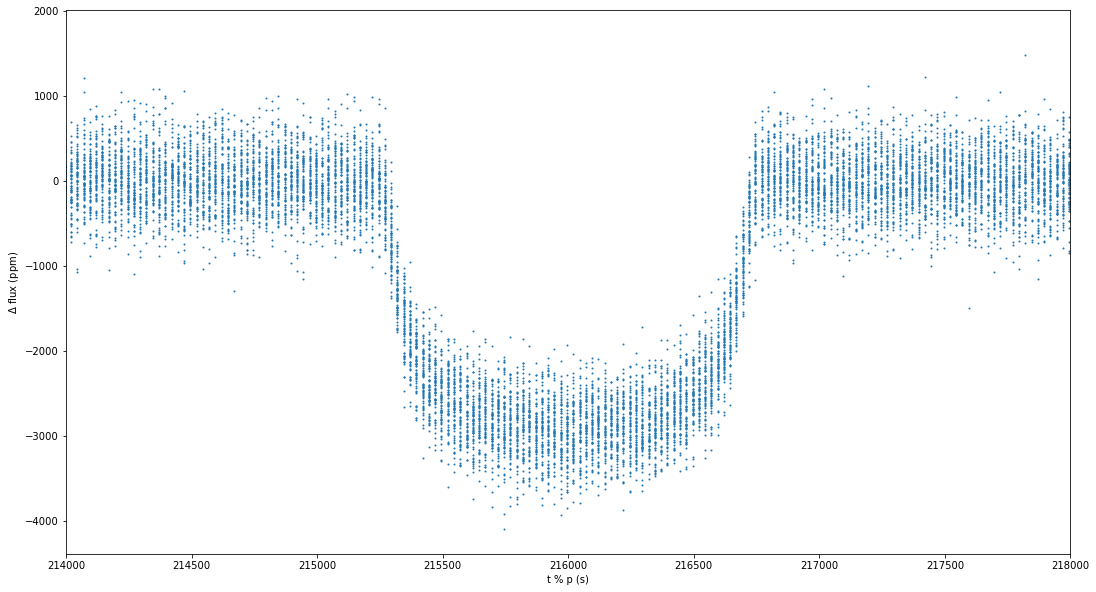

In [18]:
plot_transit(rptr_data["time"],rptr_data["dflux_ppm"],p_secs)

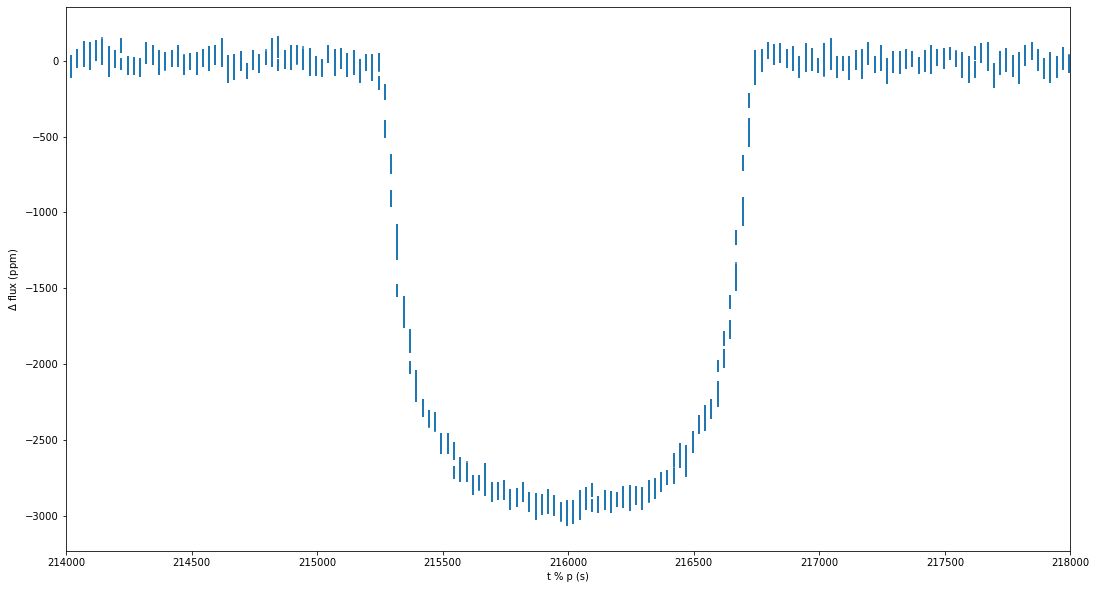

In [19]:
plot_clean_transit(rptr_data["time"], rptr_data["dflux_ppm"], p_secs)

## comparisons

### original minus rpt no rings

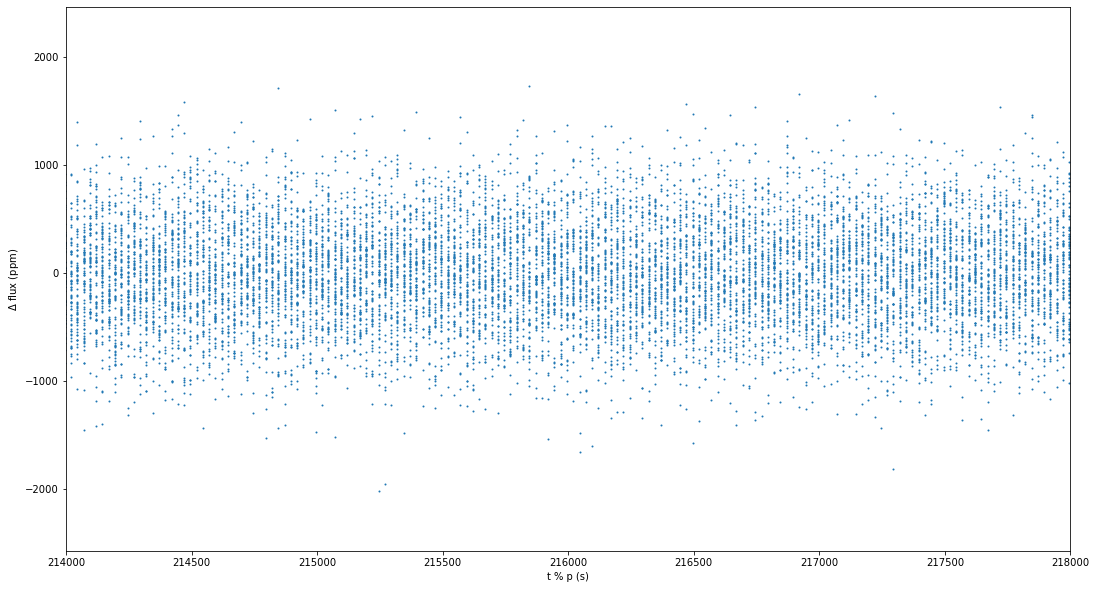

In [20]:
plot_transit(orig_data["time"],orig_data["dflux_ppm"]-rptn_data["dflux_ppm"],p_secs)

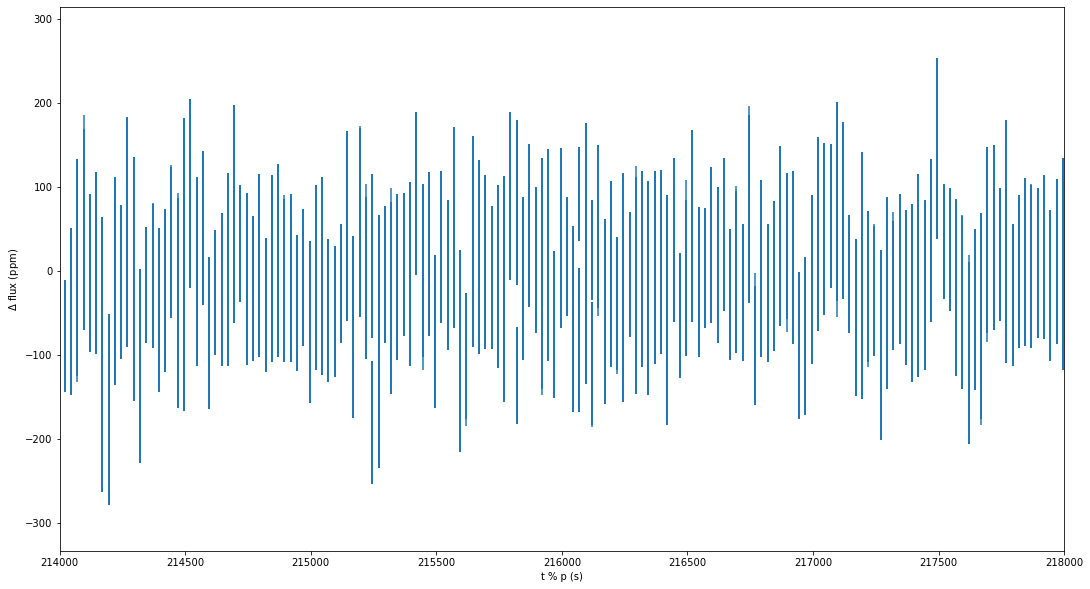

In [21]:
plot_clean_transit(rptr_data["time"], orig_data["dflux_ppm"]-rptn_data["dflux_ppm"], p_secs)

#### rpt ring minus rpt no rings

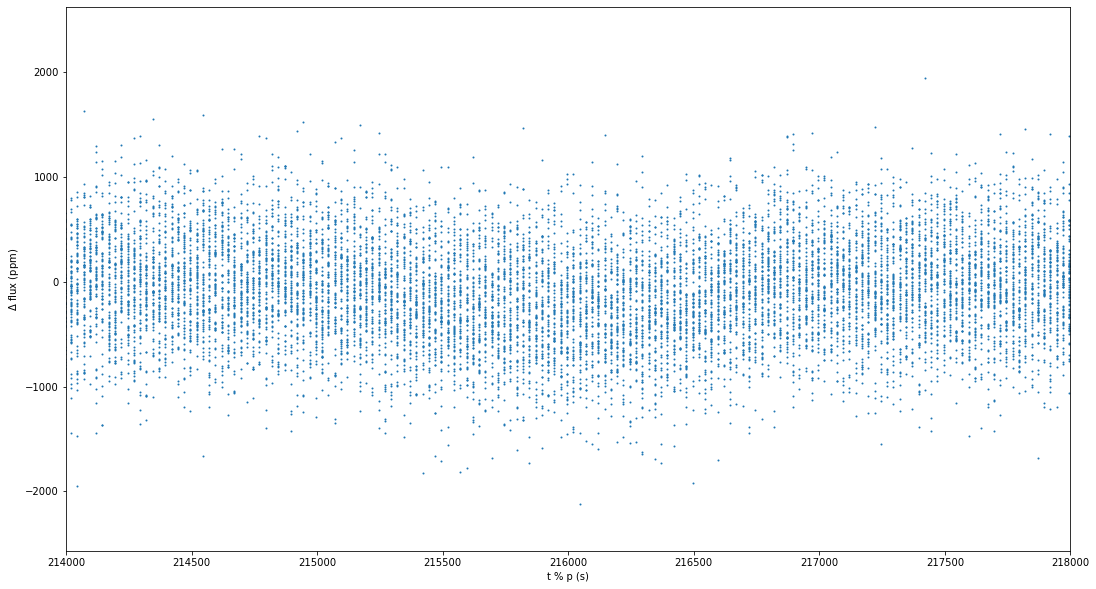

In [22]:
plot_transit(rptr_data["time"],rptr_data["dflux_ppm"]-rptn_data["dflux_ppm"],p_secs)

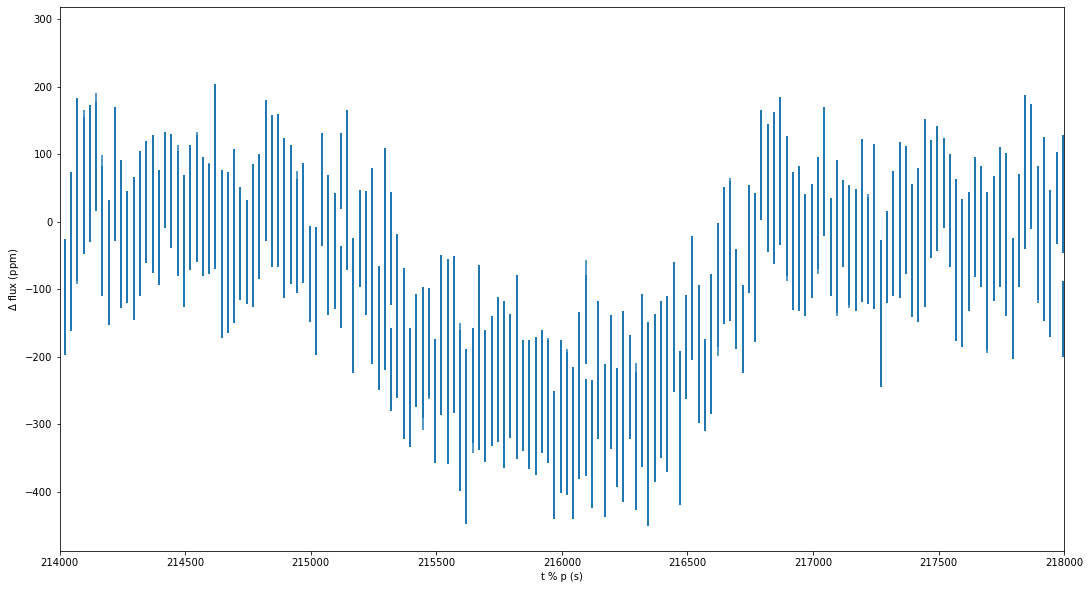

In [23]:
plot_clean_transit(rptr_data["time"], rptr_data["dflux_ppm"]-rptn_data["dflux_ppm"], p_secs)

The question now is what the residual to a best fit non-ringed planetary transit model looks like. It's pretty clear (see above) that one important impact of a ring system is a slightly deeper transit, the trouble is that's also the signal for a larger planet. The signature to look for then is at the extremes of the ingress and egress.

## final thoughts

* Here I am not modelling stellar light reflected from the planet and ring system, or the occultation of the planet by the star.
* I found a couple of minor bugs in PSLS.py, probably I should email the devs.
* It's probably worth splitting the LC out into the original camera groups.
* Modelling stellar surface variability (e.g. using Gaussian processes) is clearly key to getting the most out of the PLATO data.
* Read Barros S.C.C. et al. 2020 (A&A 634 A75)